In [18]:
import pymongo, pandas as pd, scipy.stats, matplotlib.pyplot as plt, numpy as np

# Second Hypotesis: 

In the following notebook it will be analyzed the following hypotesis:
 - **Does there exist a correlation between the number of owned games and the number of written reviews?**

## Local analysis

First we'll consider a small set of data, in order to locally perform the analysis using standard python and its libraries.<br>
If relevant results are obtained, the analysis will be replicated by using Big Data tools (HDFS, Spark, ...).

### Import json reviews dataset & select relevant features to perform the analysis

In [19]:
# Connect to the mongo local and load as a dataframe the small_reviews collection
mongo = pymongo.MongoClient()
mongo_db = mongo.final_project
small_reviews_df = pd.DataFrame(list(mongo_db.small_reviews.find({}, {'_id': False})))
mongo.close() #Close the connection

In [20]:
# Show the reviews dataframe
small_reviews_df

,base_review_id,steamid,appid,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review,unix_timestamp_created,unix_timestamp_updated
0,18,76561198058159765,204100,True,0,0,0.000000,356,336,61,3,good\n,1618048279,1618048279
1,25,76561198126769984,204100,True,0,0,0.000000,477,97,41,23,"I beat this game 5 times on ps3, when i saw th...",1617410356,1617410356
2,22,76561198372464367,204100,True,0,0,0.000000,1684,1581,135,8,one of the best 3rd person shooting game,1617507118,1617507118
3,3,76561198255525846,204100,True,0,0,0.000000,69,69,27,1,I enjoy the game. Played it to 100% on PS3 an...,1619035215,1619035215
4,27,76561198090877508,204100,True,0,0,0.000000,421,421,87,6,me cague a tiro con brazucas y me empastille a...,1617402322,1617402322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308519,77309412962,76561198945436777,598980,False,2,28,0.198423,159,41,1,1,Excuse me kind programmer this game isnt worki...,1553811131,1553811131
308520,77309413004,76561198030747313,597970,True,1,0,0.470299,1631,596,300,2,"Really fun, great game design. I like the char...",1500990434,1500990434
308521,77309413007,76561197985682990,597970,True,1,0,0.502488,1422,1402,61,3,"I just bought this game, I like it, it has a l...",1497200643,1497200643
308522,77309413014,76561197991784193,597970,True,4,0,0.543026,551,551,651,15,Age of Rivals is a really interesting card gam...,1489890474,1489890474


In [21]:
# Getting the latest details on the players (we are interested on selecting the details of the users at the latest review they written)
latest_detail_players_df = small_reviews_df.sort_values('unix_timestamp_created').groupby('steamid').tail(1)
latest_detail_players_df

# Select just the items we are interested to analyze the selected hypotesis
num_games_owned = latest_detail_players_df['num_games_owned']
num_reviews = latest_detail_players_df['num_reviews']

### Correlation test

In order to verify if there is a correlation we are considering the *Spearman's* method.

 - What is Spearman correlation? https://statisticsbyjim.com/basics/spearmans-correlation/

In [22]:
# Calculate Spearman Rank correlation and corresponding p-value
# The higher the number of owned games the higher the number of reviews (this is the meaning of the alternative greater)
statistics, p_value = scipy.stats.spearmanr(num_games_owned, num_reviews, alternative='greater')

print(f"Spearman correlation coefficient: {statistics:.3f} \nP-value: {p_value:.3f}")

# Level of significance
alpha = 0.05
# conclusion
if p_value < alpha:
    print('\nReject the null hypothesis')
else:
    print('\nDo not reject the null hypothesis')

Spearman correlation coefficient: 0.552 
P-value: 0.000

Reject the null hypothesis


### Visualize result

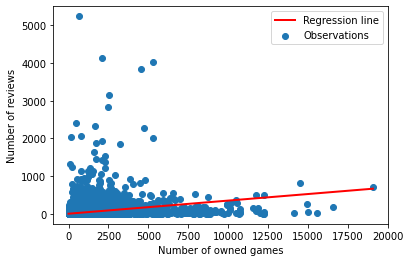

In [23]:
x = num_games_owned
y = num_reviews
plt.scatter(num_games_owned, num_reviews, label='Observations')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', linewidth=2, label='Regression line')
plt.xlabel('Number of owned games')
plt.ylabel('Number of reviews')
plt.legend()
plt.show()

### Variant hypotesis: 
 - **People that owns lot of games tend to review most of their games?**

In [24]:
reviews_ratio = num_reviews / num_games_owned
statistics, p_value = scipy.stats.spearmanr(num_games_owned, reviews_ratio, alternative='greater')
print(f"Spearman correlation coefficient: {statistics:.3f} \nP-value: {p_value:.3f}")
# Level of significance
alpha = 0.05
# conclusion
if p_value < alpha:
    print('\nReject the null hypothesis')
else:
    print('\nDo not reject the null hypothesis')

Spearman correlation coefficient: -0.521 
P-value: 1.000

Do not reject the null hypothesis


We can see from the p-value that the variant hypotesis is not statistically significant.

## Big data analysis